In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-04 15:34:34,670 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [42]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [43]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        y_test = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])

#         y_test['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_test['compactness'] / (4 * np.pi))))
#         y_pred['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_pred['compactness'] / (4 * np.pi))))
        
#         idx = np.isclose(y_pred['compactness'], 1)
#         y_pred['orientation'][idx] = 0
#         y_pred['eccentricity'][idx] = 0
#         idx = np.isclose(y_test['compactness'], 1)
#         y_test['orientation'][idx] = 0
#         y_test['eccentricity'][idx] = 0
            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
#             'adjust_bias': adjust_bias,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [44]:
results_dir = '../../results/shape8cv/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 62 files


In [45]:
subjects = ['S1', 'S2', 'S3', 'S4']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [46]:
data = load_data(pickle_files, verbose=False)

In [47]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [48]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [57]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

best_train_cost                          axlambda  \
                                 count       mean       std         mean   
subject model idx_fold                                                     
S1      C     0                      5   6.127087  0.189118  2083.983385   
              1                      5   4.638570  0.327571  2323.182784   
              2                      5   5.882684  0.068408  2068.551787   
              3                      5   5.135686  0.240603  1899.884999   
              4                      5   5.173329  0.247487  2063.523583   
              5                      5   5.505042  0.268457  2023.356415   
              6                      5   5.783187  0.309842  1876.114927   
              7                      5   6.235225  0.384265  2172.059209   
              8                      5   5.285287  0.202669  2443.981497   
              9                      7   5.552927  0.125074  2629.622479   
S2      C     13                     2   6.134185  0.537344   683.254241   
              5                      1   7.534027       NaN  1984.280633   
              6                      1   6.092078       NaN  1245.720185   
              7                      1   6.046054       NaN  2241.809002   
S3      C     0                      1  21.999680       NaN  1455.225298   
S4      C     0                      2   4.313547  0.173924  2938.434932   
              13                     1   4.793206       NaN  2113.174176   
              15                     1   5.023683       NaN  3000.000000   

                                            rho             
                                std        mean        std  
subject model idx_fold                                      
S1      C     0          503.805547  327.596440  22.196643  
              1          649.777710  310.148644  66.589260  
              2          443.252305  276.008196  32.573325  
              3         1038.129368  233.616478  74.967559  
              4          311.134172  290.343868  51.389782  
              5          888.523374  295.617801  55.862476  
              6          791.288785  297.965682  57.686892  
              7          871.972607  301.407620  85.450173  
              8          618.258617  243.118443  60.734482  
              9          243.523632  293.341923  38.667827  
S2      C     13         442.575043  308.591246  58.215206  
              5                 NaN  216.773848        NaN  
              6                 NaN  266.465299        NaN  
              7                 NaN  275.090234        NaN  
S3      C     0                 NaN   74.238444        NaN  
S4      C     0           87.066154  546.023908  39.837150  
              13                NaN  581.720794        NaN  
              15                NaN  551.423295        NaN

# The best runs in their respective category

In [59]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


best_train_cost                axlambda         rho
                                 count        min         mean        mean
subject model idx_fold                                                    
S1      C     0                      1   5.955429  2134.229022  306.580865
              1                      1   4.151747  2329.401687  308.268832
              2                      1   5.814248  1882.574200  319.650344
              3                      1   4.828592  2195.956444  206.360860
              4                      1   4.960296  2231.992528  314.414878
              5                      1   5.157463  2581.875843  314.082767
              6                      1   5.430022  2916.006925  307.182174
              7                      1   5.946435  2729.586256  310.506366
              8                      1   5.077319  2543.954581  205.998440
              9                      1   5.414133  2683.771257  308.265289
S2      C     5                      1   7.534027  1984.280633  216.773848
              6                      1   6.092078  1245.720185  266.465299
              7                      1   6.046054  2241.809002  275.090234
              13                     1   5.754226   370.306427  349.755613
S3      C     0                      1  21.999680  1455.225298   74.238444
S4      C     0                      1   4.190564  2876.869865  574.193027
              13                     1   4.793206  2113.174176  581.720794
              15                     1   5.023683  3000.000000  551.423295

In [11]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,6.119315e+00,C,-1.313690,-0.515385,-0.934147,6.439076e-01,S1,area compactness eccentricity orientat...,area compactness eccentricity orienta...
1,3.094250e+02,C,-236.454349,-20.377237,-31.306309,-1.728713e+01,S2,area compactness eccentricity orienta...,area compactness eccentricity orienta...
2,6.662580e+15,C,0.000000,0.000000,0.000000,-6.662580e+15,S3,area compactness eccentricity orientati...,area compactness eccentricity orientat...
3,1.396330e+01,C,-8.921216,-1.436474,-0.229360,6.237527e-01,S4,area compactness eccentricity orient...,area compactness eccentricity orienta...


# Plot predictions

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


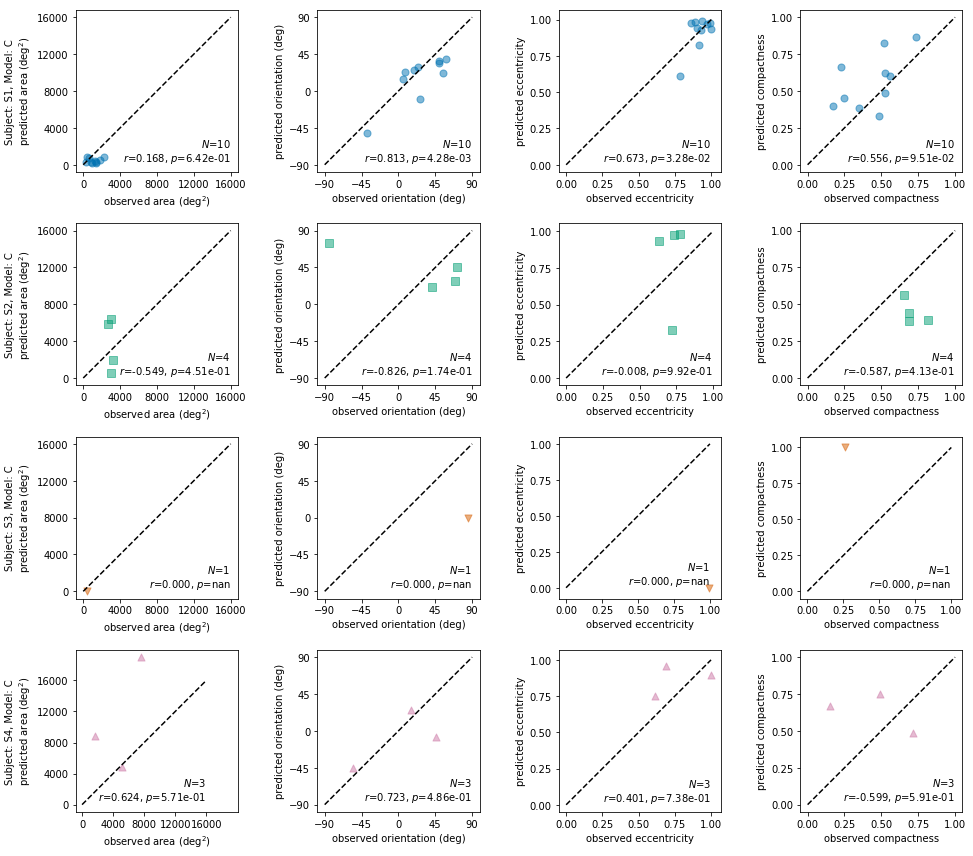

In [12]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 16000], [-90, 90], [0, 1], [0, 1]]
limits = [[-1600, 16600], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.png' % plotmodel)